# Global mean Sea Surface Temperatures

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

from calendar import monthrange

from dask.distributed import Client
from dask import delayed
import dask

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pyproj

from globales import *
plt.rcParams['figure.figsize'] = (10, 4)

## Load data

In [3]:
base_file = GlobalSU['DatPath'] + '/Satelite/MUR/NC/'

In [4]:
year1= 2003
year2= 2024
files = []
for iy in range(year1,year2+1):
    for im in range(1,13):
        for id in range(1,monthrange(iy,im)[1]+1):
            files.append(base_file+"%04d%02d%02d090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"%(iy,im,id))

In [5]:
def drop_coords(ds):
    ds = ds.get(['analysed_sst'])
    return ds.reset_coords(drop=True)

DS = xr.open_mfdataset(files,combine='nested', concat_dim="time", parallel=True, 
                       combine_attrs= "drop", preprocess=drop_coords, 
                       autoclose = True, data_vars='minimal', coords="minimal")

In [7]:
ts=DS.analysed_sst.sel(lat=20,lon=-25).load()

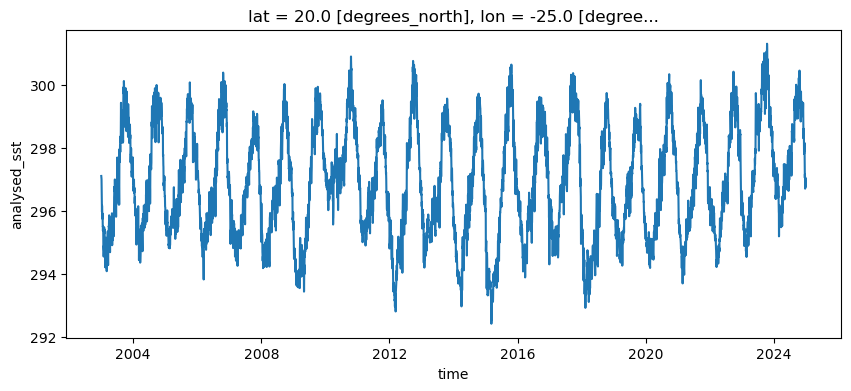

In [9]:
ts.plot()

## Climatology

In [10]:
sst_climatology = ts.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

In [11]:
sst_anomaly = ts.groupby('time.dayofyear')-sst_climatology
sst_anomaly_monthly = sst_anomaly.resample(time='1MS').mean(keep_attrs=True,skipna=False)

## Plots

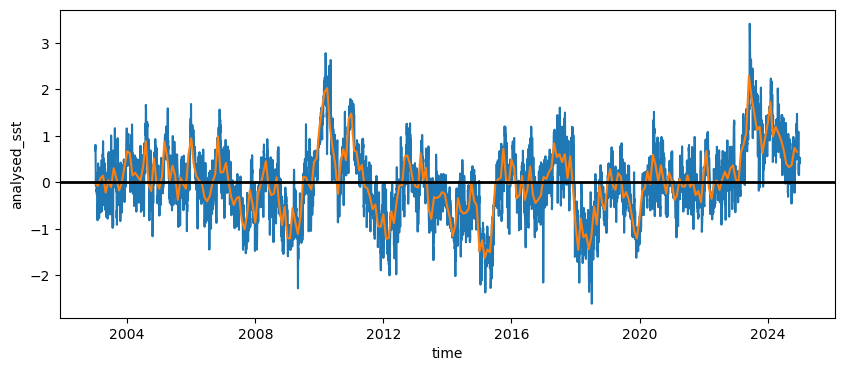

In [12]:
#plot the data
sst_anomaly.plot()
sst_anomaly_monthly.plot()
plt.axhline(linewidth=2,color='k')